In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from ta.trend import MACD

In [2]:
def get_historical_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    data.dropna(inplace=True)
    print(data)
    return data


In [14]:
def calculate_macd(data):
    macd_indicator = MACD(close=data['Close'], window_slow=100, window_fast=50, window_sign=9)
    data['MACD_Line'] = macd_indicator.macd()
    data['Signal_Line'] = macd_indicator.macd_signal()
    data['MACD_Hist'] = macd_indicator.macd_diff()
    return data


In [4]:
def implement_macd_strategy(data):
    data['Signal'] = 0
    data['Signal'] = np.where(data['MACD_Line'] > data['Signal_Line'], 1, 0)
    data['Position'] = data['Signal'].diff()
    return data


In [5]:
def backtest_strategy(data):
    # Buy/Sell prices
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0  # 1 means buy, -1 means sell

    for i in range(len(data)):
        if data['MACD_Line'][i] > data['Signal_Line'][i]:
            if signal != 1:
                buy_price.append(data['Close'][i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['MACD_Line'][i] < data['Signal_Line'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data['Close'][i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)

    data['Buy_Price'] = buy_price
    data['Sell_Price'] = sell_price
    data['MACD_Signal'] = macd_signal

    # Calculate returns
    data['Market_Returns'] = data['Close'].pct_change()
    data['Strategy_Returns'] = data['Market_Returns'] * data['Signal'].shift(1)
    cumulative_returns = (1 + data['Strategy_Returns']).cumprod() - 1
    return data, cumulative_returns


In [6]:
def plot_results(data, symbol):
    plt.figure(figsize=(14, 7))

    # Plot stock prices and buy/sell signals
    plt.subplot(2, 1, 1)
    plt.plot(data['Close'], label='Close Price', alpha=0.5)
    plt.scatter(data.index, data['Buy_Price'], color='green', label='Buy Signal', marker='^', alpha=1)
    plt.scatter(data.index, data['Sell_Price'], color='red', label='Sell Signal', marker='v', alpha=1)
    plt.title(f'{symbol} Price Chart with Buy/Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    # Plot MACD and Signal Line
    plt.subplot(2, 1, 2)
    plt.plot(data['MACD_Line'], label='MACD Line', color='blue', alpha=0.5)
    plt.plot(data['Signal_Line'], label='Signal Line', color='red', alpha=0.5)
    plt.bar(data.index, data['MACD_Hist'], label='MACD Histogram', color='grey', alpha=0.3)
    plt.title('MACD Indicator')
    plt.xlabel('Date')
    plt.ylabel('MACD')
    plt.legend()

    plt.tight_layout()
    plt.show()


[*********************100%***********************]  1 of 1 completed


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-03  122.820000  126.370003  122.279999  124.739998  124.365547   
2023-01-04  127.379997  129.050003  125.849998  127.370003  126.987656   
2023-01-05  126.129997  128.520004  124.540001  126.940002  126.558945   
2023-01-06  128.970001  130.330002  126.040001  130.020004  129.629700   
2023-01-09  131.160004  132.949997  129.279999  129.470001  129.081360   
...                ...         ...         ...         ...         ...   
2024-09-16  524.539978  534.099976  517.400024  533.280029  533.280029   
2024-09-17  537.599976  542.099976  530.570007  536.320007  536.320007   
2024-09-18  537.070007  544.200012  533.900024  537.950012  537.950012   
2024-09-19  550.000000  562.070007  546.520020  559.099976  559.099976   
2024-09-20  559.979980  564.500000  556.300110  561.349976  561.349976   

              Volume  
Date          

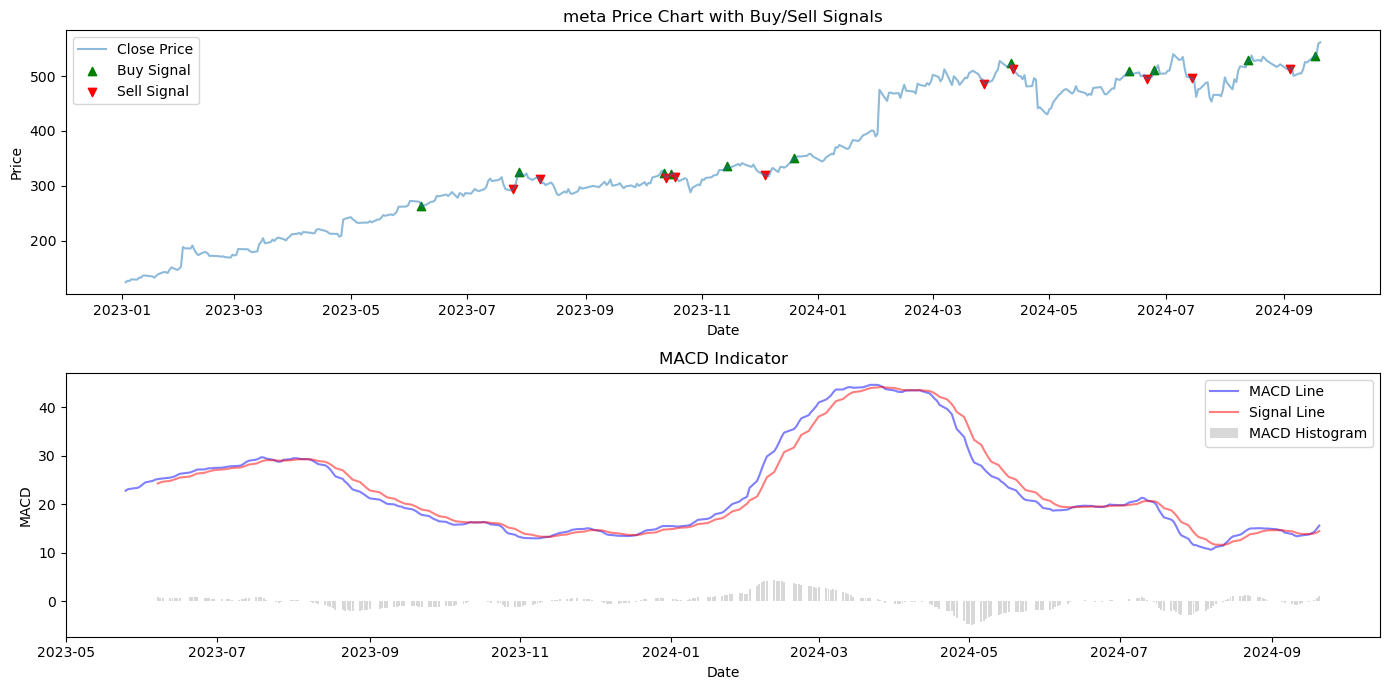

In [20]:
if __name__ == "__main__":
    symbol = 'meta'  # Apple Inc.
    start_date = '2023-01-01'
    end_date = '2024-10-01'

    data = get_historical_data(symbol, start_date, end_date)

    data = calculate_macd(data)

    data = implement_macd_strategy(data)

    # Backtest strategy
    data, cumulative_returns = backtest_strategy(data)

    print(f"Cumulative Returns: {cumulative_returns.iloc[-1]:.2%}")

    plot_results(data, symbol)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from ta.trend import MACD
import time
import datetime as dt
import yfinance as yf
from dotenv import load_dotenv
import os

# Load environment variables from the .env file
load_dotenv()

API_KEY = os.getenv('API_KEY')
API_SECRET = os.getenv('API_SECRET')
APCA_API_BASE_URL = 'https://paper-api.alpaca.markets'

# Initialize Alpaca API
api = tradeapi.REST(API_KEY, API_SECRET, APCA_API_BASE_URL, api_version='v2')

def get_real_time_data(symbol, interval='1m', period='1d'):
    data = yf.download(tickers=symbol, period=period, interval=interval, progress=False)
    data.dropna(inplace=True)
    return data

def calculate_macd(data):
    macd_indicator = MACD(close=data['Close'], window_slow=26, window_fast=12, window_sign=9)
    data['MACD_Line'] = macd_indicator.macd()
    data['Signal_Line'] = macd_indicator.macd_signal()
    data['MACD_Hist'] = macd_indicator.macd_diff()
    return data

def generate_signals(data):
    data['Signal'] = 0
    data['Signal'] = np.where(data['MACD_Line'] > data['Signal_Line'], 1, 0)
    data['Position'] = data['Signal'].diff()
    return data

def place_order(symbol, qty, side, order_type='market'):
    try:
        api.submit_order(
            symbol=symbol,
            qty=qty,
            side=side,
            type=order_type,
            time_in_force='day'
        )
        print(f"Order placed: {side} {qty} shares of {symbol}")
    except Exception as e:
        print(f"Error placing order for {symbol}: {e}")

def get_current_position(symbol):
    try:
        position = api.get_position(symbol)
        qty = float(position.qty)
        return qty
    except tradeapi.rest.APIError as e:
        if 'position does not exist' in str(e):
            return 0
        else:
            print(f"Error fetching position for {symbol}: {e}")
            return 0

def is_market_open():
    now = dt.datetime.now()
    market_open = now.replace(hour=9, minute=30, second=0, microsecond=0)
    market_close = now.replace(hour=16, minute=0, second=0, microsecond=0)
    if now.weekday() >= 5:  # 5 = Saturday, 6 = Sunday
        return False
    return market_open <= now <= market_close

def get_time_to_market_close():
    now = dt.datetime.now()
    market_close = now.replace(hour=16, minute=0, second=0, microsecond=0)
    if now.weekday() >= 5:
        return None
    time_to_close = (market_close - now).total_seconds()
    if time_to_close < 0:
        return None
    return time_to_close

def plot_data(data, symbol):
    plt.figure(figsize=(14, 7))

    # Plot stock prices and buy/sell signals
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(data['Close'], label='Close Price', alpha=0.5)
    buy_signals = data[data['Position'] == 1]
    sell_signals = data[data['Position'] == -1]
    ax1.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', marker='^', color='green', s=100)
    ax1.scatter(sell_signals.index, sell_signals['Close'], label='Sell Signal', marker='v', color='red', s=100)
    ax1.set_title(f'{symbol} Price Chart with Buy/Sell Signals')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.legend()

    # Plot MACD and Signal Line
    ax2 = plt.subplot(2, 1, 2)
    ax2.plot(data['MACD_Line'], label='MACD Line', color='blue', alpha=0.5)
    ax2.plot(data['Signal_Line'], label='Signal Line', color='red', alpha=0.5)
    ax2.bar(data.index, data['MACD_Hist'], label='MACD Histogram', color='grey', alpha=0.3)
    ax2.set_title('MACD Indicator')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('MACD')
    ax2.legend()

    plt.tight_layout()
    plt.show(block=False)
    plt.pause(0.1)
    plt.close()

def run_trading_bot():
    symbols = ['AAPL', 'MSFT', 'GOOGL']  
    investment_amount = 10000  

    # Enable interactive mode
    plt.ion()

    # Trading loop
    while True:
        market_open = is_market_open()
        # if market_open:
        for symbol in symbols:
            print(f"\nProcessing {symbol} at {dt.datetime.now()}")

            # Fetch data
            data = get_real_time_data(symbol)
            if data.empty:
                print(f"No data retrieved for {symbol}. Retrying in next cycle...")
                continue

            data = calculate_macd(data)
            data = generate_signals(data)

            # Plot data
            plot_data(data, symbol)

            # Get the latest signal
            latest_signal = data['Position'].iloc[-1]
            current_price = data['Close'].iloc[-1]
            qty_owned = get_current_position(symbol)

            if latest_signal == 1 and qty_owned == 0:
                qty = int(investment_amount / current_price)
                if qty > 0:
                    print(f"Buy signal detected for {symbol} at {dt.datetime.now()}")
                    place_order(symbol, qty, 'buy')
            elif latest_signal == -1 and qty_owned > 0:
                print(f"Sell signal detected for {symbol} at {dt.datetime.now()}")
                place_order(symbol, qty_owned, 'sell')

            time_to_close = get_time_to_market_close()
            if time_to_close is not None and time_to_close < 15 * 60 and qty_owned > 0:
                print(f"Closing position for {symbol} before market close.")
                place_order(symbol, qty_owned, 'sell')

            time.sleep(1)

        print("Cycle complete. Sleeping for 60 seconds.")
        time.sleep(60)
        # else:
        #     print("Market is closed. Waiting for market to open...")
        #     time.sleep(300)  # Sleep for 5 minutes when market is closed

if __name__ == "__main__":
    try:
        run_trading_bot()
    except KeyboardInterrupt:
        print("\nTrading bot stopped by user.")
    except Exception as e:
        print(f"An error occurred: {e}")
